# Dynamic Linear Model

In [8]:
import os
import math

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import NcvContinuous
from pyro.contrib.tracking.measurements import PositionMeasurement
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam, AutoReparam
from pyro.ops.stats import quantile

from main import get_energy_data, get_weather_data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

pyro.set_rng_seed(20200928)
torch.manual_seed(20200101)

pd.set_option('display.max_rows', 500)



In [58]:
list(dfW.columns)

['temp',
 'temp',
 'temp_min',
 'temp_max',
 'pressure',
 'humidity',
 'wind_speed',
 'wind_deg',
 'rain_1h',
 'rain_3h',
 'snow_3h']

## Data

In [67]:
T = None # number of time steps to include, if None all data is used
test_frac = 0.1 # fraction of data to use for testing

# read data
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None
df = df.asfreq("D") # aggregate data, can be commented out to use all data
dfW = get_weather_data(df)
dfE = get_energy_data(df)


# start, train end, test end
n = len(df) if T is None else T
T0 = 0
T1 = n - int(test_frac*n) # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

# convert to torch tensors
# X_W = torch.from_numpy(dfW.values).float()
# X_E = torch.from_numpy(dfE.values).float()
# obs = torch.from_numpy(df["price actual"].values).float()

# standardize data
df_standardized = dfE.merge(dfW, left_index=True, right_index=True)
df_standardized["price_ actual"] = df["price actual"]
scaler = StandardScaler().fit(df_standardized[:T1])
df_standardized = scaler.transform(df_standardized)
df_standardized = pd.DataFrame(df_standardized, columns=list(dfW.columns) + list(dfE.columns) + ["price_actual"], index = df.index)
# print(df_standardized.columns)

# create tensors
X_W = torch.from_numpy(df_standardized[dfW.columns].values).float()
X_E = torch.from_numpy(df_standardized[dfE.columns].values).float()
obs = torch.from_numpy(df_standardized["price_actual"].values).float()

# translate to pyro forecasting language
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]
# covariates = X_E if T is None else X_E[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting



# covariates[:T1].mean(axis = 0), covariates.std(axis = 0)


Number of observations: 1461
Number of training observations: 1315
Number of test observations: 146


## Model

### Old models

#### Linear DLM

INFO 	 step    0 loss = 176.105
INFO 	 step  100 loss = 126.998
INFO 	 step  200 loss = 121.47
INFO 	 step  300 loss = 116.794
INFO 	 step  400 loss = 112.935
INFO 	 step  500 loss = 110.079
INFO 	 step  600 loss = 107.519
INFO 	 step  700 loss = 106.258
INFO 	 step  800 loss = 103.79
INFO 	 step  900 loss = 102.46


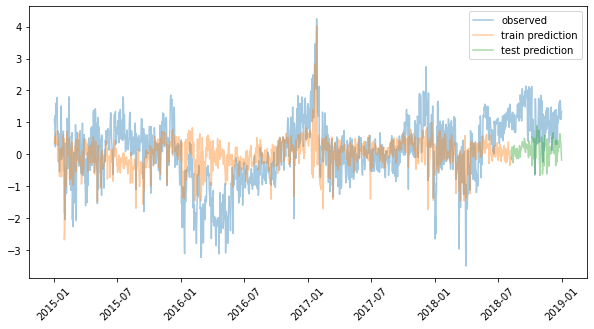

In [69]:
class LinearDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        self.h_dim = X_E.shape[1]
        self.gamma = 1e-6

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        covariates = x_E

        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        # draw parameters
        theta_g = pyro.sample("theta_g", dist.Normal(torch.zeros(self.h_dim), torch.ones(self.h_dim)).to_event(1))
        # print("theta_g: ", theta_g.shape)

        # weight = theta_g
        with self.time_plate:
            R = pyro.sample("R", dist.HalfCauchy(self.gamma*torch.ones(feature_dim)).to_event(1))
            # with poutine.reparam(config={"h_param": AutoReparam()}):
            h = pyro.sample("h", dist.Normal(covariates, R).to_event(1))
        pyro.deterministic("h_data", h)
        # h = covariates
        # print("h: ", h.shape, "covariates: ", covariates.shape, h.shape == covariates.shape)
        # record in model_trace
        # pyro.deterministic("weight", weight)

        # prediction = (weight * covariates).sum(-1, keepdim=True)
        prediction = (theta_g*h).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, prediction)

pyro.set_rng_seed(1)
pyro.clear_param_store()
model = LinearDLM()
guide = AutoNormal(poutine.block(model, hide=[f"z_{i}" for i in range(T1+1)]))
# optim = Adam({ 'lr': 1e-3 })
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
    guide = guide,
    # optim = optim,
)

with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(dates, y, label="observed", alpha= .4)
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

#### Linear with hidden states

INFO 	 step    0 loss = 79.5865
INFO 	 step  100 loss = 22.8771
INFO 	 step  200 loss = 21.3568
INFO 	 step  300 loss = 20.3233
INFO 	 step  400 loss = 20.1342
INFO 	 step  500 loss = 19.148
INFO 	 step  600 loss = 18.4906
INFO 	 step  700 loss = 18.0504
INFO 	 step  800 loss = 17.585
INFO 	 step  900 loss = 17.6951


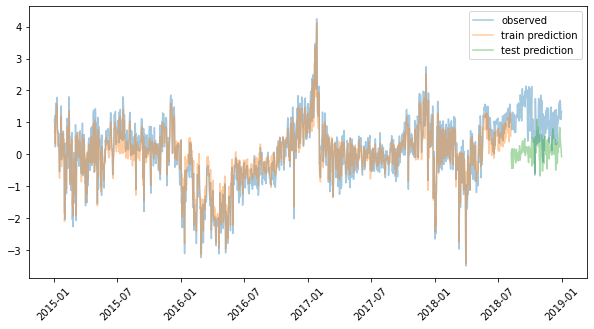

Mean price:  tensor(0.1096)
Mean abs residual:  tensor(0.8648)
Mean abs train residual:  tensor(0.3550)
Mean abs test residual:  tensor(5.4561)


In [ ]:
class LinearDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        # self.h_dim = X_E.shape[1]
        self.h_dim = 20
        self.gamma = 1
        self.lambda_f = 1

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        covariates = x_E

        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        # draw parameters
        theta_g = pyro.sample("theta_g", dist.Normal(torch.zeros(self.h_dim), torch.ones(self.h_dim)).to_event(1))
        theta_f = pyro.sample("theta_f", dist.Normal(torch.zeros((feature_dim, self.h_dim)), torch.ones((feature_dim, self.h_dim)) * self.lambda_f).to_event(2))
        # print("theta_g: ", theta_g.shape)

        # weight = theta_g

        with self.time_plate:
            R = pyro.sample("R", dist.HalfCauchy(self.gamma*torch.ones(self.h_dim)).to_event(1))
            # with poutine.reparam(config={"h_param": LocScaleReparam()}):
            # print(covariates.unsqueeze(-1).shape, theta_f.shape)
            h_mean = (theta_f*covariates.unsqueeze(-1)).sum(-2, keepdim=True).squeeze(-2)
            # print("h_mean: ", h_mean.shape, "R: ",R.shape)
            h = pyro.sample("h", dist.Normal(h_mean, R).to_event(1))
        pyro.deterministic("h_data", h)

        # prediction 
        # print("theta_g: ", theta_g.shape, "h: ", h.shape)
        prediction = (theta_g*h).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, prediction)

pyro.set_rng_seed(1)
pyro.clear_param_store()
model = LinearDLM()
guide = AutoNormal(poutine.block(model, hide=[f"z_{i}" for i in range(T1+1)]))
# optim = Adam({ 'lr': 1e-3 })
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
    guide = guide,
    # optim = optim,
)

with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(dates, y, label="observed", alpha= .4)
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

resid = obs - posterior_samples['prediction'].squeeze()
print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs test residual: ", resid[:, T1:].abs().mean())

### New models

INFO 	 step    0 loss = 79.5865
INFO 	 step  100 loss = 22.8771
INFO 	 step  200 loss = 21.3568
INFO 	 step  300 loss = 20.3233
INFO 	 step  400 loss = 20.1342
INFO 	 step  500 loss = 19.148
INFO 	 step  600 loss = 18.4906
INFO 	 step  700 loss = 18.0504
INFO 	 step  800 loss = 17.585
INFO 	 step  900 loss = 17.6951


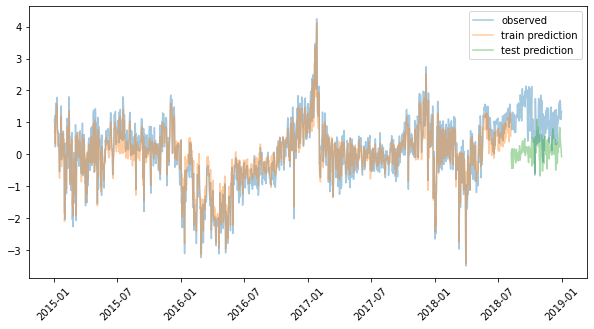

Mean price:  tensor(0.1096)
Mean abs residual:  tensor(0.8648)
Mean abs train residual:  tensor(0.3550)
Mean abs test residual:  tensor(5.4561)


In [68]:
class LinearDLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        # self.h_dim = X_E.shape[1]
        self.h_dim = 20
        self.gamma = 1
        self.lambda_f = 1

    def model(self, zero_data, covariates):
        x_E = covariates[:, :X_E.shape[1]]
        x_W = covariates[:, -X_W.shape[1]:]
        covariates = x_E

        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        # draw parameters
        theta_g = pyro.sample("theta_g", dist.Normal(torch.zeros(self.h_dim), torch.ones(self.h_dim)).to_event(1))
        theta_f = pyro.sample("theta_f", dist.Normal(torch.zeros((feature_dim, self.h_dim)), torch.ones((feature_dim, self.h_dim)) * self.lambda_f).to_event(2))
        # print("theta_g: ", theta_g.shape)

        # weight = theta_g

        with self.time_plate:
            R = pyro.sample("R", dist.HalfCauchy(self.gamma*torch.ones(self.h_dim)).to_event(1))
            h_mean = (theta_f*covariates.unsqueeze(-1)).sum(-2, keepdim=True).squeeze(-2)
            with poutine.reparam(config={"h_param": CosineReparam()}):
            # print(covariates.unsqueeze(-1).shape, theta_f.shape)
            
            # print("h_mean: ", h_mean.shape, "R: ",R.shape)
                h = pyro.sample("h", dist.Normal(h_mean, R).to_event(1))
        pyro.deterministic("h_data", h)

        # prediction 
        # print("theta_g: ", theta_g.shape, "h: ", h.shape)
        prediction = (theta_g*h).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, prediction)

pyro.set_rng_seed(1)
pyro.clear_param_store()
model = LinearDLM()
guide = AutoNormal(poutine.block(model, hide=[f"z_{i}" for i in range(T1+1)]))
# optim = Adam({ 'lr': 1e-3 })
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
    guide = guide,
    # optim = optim,
)

with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(dates, y, label="observed", alpha= .4)
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

resid = obs - posterior_samples['prediction'].squeeze()
print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs test residual: ", resid[:, T1:].abs().mean())

## Inference

In [ ]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = VanillaDLM()
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

In [30]:
pyro.set_rng_seed(1)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

# posterior_samples["prediction"].shape


## Analyze posterior samples

In [31]:
posterior_samples.keys()

dict_keys(['particles', 'time', 'drift_scale', 'drift_decentered', 'drift', 'weight', 'prediction', 'noise_scale', 'residual'])

In [32]:
# extract percentiles of the posterior samples
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)

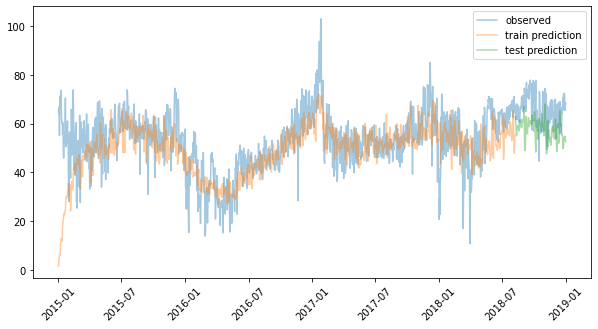

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

Mean price:  tensor(53.7429)
Mean abs residual:  tensor(12.9040)
Mean abs train residual:  tensor(12.5122)
Mean abs residual:  tensor(16.4330)


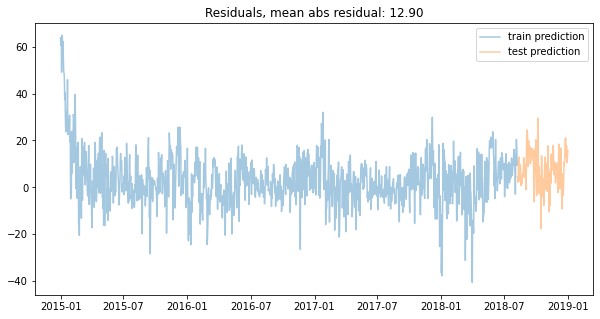

In [34]:
resid = obs - posterior_samples['prediction'].squeeze()

resid_p10, resid_p50, resid_p90 = quantile(resid, (0.1, 0.5, 0.9)).squeeze(-1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], resid_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], resid_p50[T1:], label="test prediction", alpha = .4)
# ax.fill_between(dates, resid_p10, resid_p90, color="red", alpha=0.3)
ax.legend()
ax.set_title("Residuals, mean abs residual: {:.2f}".format(resid.abs().mean()))

print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs residual: ", resid[:, T1:].abs().mean())

In [35]:
# resid[T1:]
resid.shape

torch.Size([100, 1461])